In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [11]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [152]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def abstract_batches(self, size):
        for chunk in chunked_iter(self.abstracts(), size):
            yield AbstractBatch(chunk)

In [153]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def tensor(self):
        return torch.stack([s.tensor() for s in self.sentences])

In [154]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [182]:
@attr.s
class AbstractBatch:
    
    abstracts = attr.ib()
    
    def tensor(self):
        tensors = [a.tensor() for a in self.abstracts]
        return torch.cat(tensors)
    
    def xy(self, encoded_sents):
        
        x, y = [], []
        
        start = 0
        for ab in self.abstracts:
            sents = encoded_sents[start:start+len(ab.sentences)]
            for s1, s2 in pairwise(sents):
                
                # Correct.
                x.append(torch.cat([s1, s2]))
                y.append(1)
                
                # Incorrect.
                x.append(torch.cat([s2, s1]))
                y.append(0)
                
            start += len(ab.sentences)
            
        return torch.stack(x), torch.FloatTensor(y)

In [282]:
class SentenceEncoder(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu', batch_first=True)
        
    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_dim))
        
    def forward(self, x):
        hidden = self.init_hidden()
        rnn_out, hidden = self.rnn(x, hidden)
        return hidden

In [283]:
class Model(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.i2h = nn.Linear(2*input_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        y = F.relu(self.i2h(x))
        y = F.sigmoid(self.h2o(y))
        return y

In [312]:
train = Corpus('../data/train.json/*.json', 1000)

In [330]:
torch.manual_seed(1)

In [338]:
sent_encoder = SentenceEncoder(300, 150)

In [332]:
model = Model(150, 150)

In [333]:
criterion = nn.MSELoss()

In [334]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5)

In [335]:
train_loss = []
for epoch in range(10):

    epoch_loss = 0
    for batch in train.abstract_batches(30):

        sent_encoder.zero_grad()
        model.zero_grad()

        sents = Variable(batch.tensor())
        sents = sent_encoder(sents)

        x, y = batch.xy(sents.squeeze())
        y = Variable(y)

        y_pred = model(x)
        y_pred = y_pred.view(-1)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.data[0]
        
    train_loss.append(epoch_loss)
    
    print(f'Epoch {epoch}')
    print(epoch_loss)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 0
8.505680322647095


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 1
8.503427058458328


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 2
8.502246350049973


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 3
8.501443862915039


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 4
8.500868320465088


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 5
8.5004503428936


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 6
8.500143826007843


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 7
8.49991199374199


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 8
8.499748513102531


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 9
8.499631598591805


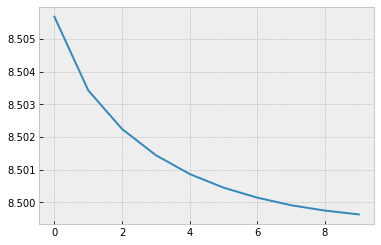

In [336]:
plt.plot(train_loss)

In [337]:
for batch in train.abstract_batches(30):

    sents = Variable(batch.tensor())
    sents = sent_encoder(sents)

    x, y = batch.xy(sents.squeeze())
    y = Variable(y)

    y_pred = model(x)
    y_pred = y_pred.view(-1)

    print(y_pred, y)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.4975
 0.4859
 0.4859
 0.4975
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.4948
 0.4943
 0.4943
 0.4948
 0.5014
 0.5014
 0.5014
 0.5014
 0.

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5003
 0.4869
 0.4869
 0.5003
 0.5014
 0.5014
 0.5007
 0.4852
 0.4852
 0.5007
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5009
 0.4848
 0.4848
 0.5009
 0.5014
 0.5014
 0.

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5044
 0.4876
 0.4876
 0.5044
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.4992
 0.4973
 0.4973
 0.4992
 0.5039
 0.4836
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.4992
 0.4933
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5013
 0.5015
 0.5015
 0.5013
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.

Variable containing:
 0.5013
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5015
 0.5014
 0.5014
 0.5015
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.

Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.


Variable containing:
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0.5014
 0